## **Atelier 1 : Analyse de Sentiments sur les Commentaires YouTube**

**Par :** *Nouha EL MHAMDI*

### **Partie 1 : Importation et Exploration des Données**

#### **1. Importer les bibliothèques nécessaires**
Cette cellule importe toutes les bibliothèques nécessaires pour l'atelier, telles que pandas pour la manipulation des données, et os pour les opérations sur le système de fichiers.

In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Embedding
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

#### **2. Charger les fichiers CSV**
Cette cellule charge les fichiers CSV individuels de commentaires YouTube dans une liste de DataFrames pandas.

In [2]:
files = [r'C:\Users\HP\Career\MASTER ML&AI\Advanced Natural Language Processing\Advanced-Natural-Language-Processing\Analyse de Sentiments sur les Commentaires\data\Youtube01-Psy.csv',
         r'C:\Users\HP\Career\MASTER ML&AI\Advanced Natural Language Processing\Advanced-Natural-Language-Processing\Analyse de Sentiments sur les Commentaires\data\Youtube02-KatyPerry.csv',
         r'C:\Users\HP\Career\MASTER ML&AI\Advanced Natural Language Processing\Advanced-Natural-Language-Processing\Analyse de Sentiments sur les Commentaires\data\Youtube03-LMFAO.csv',
         r'C:\Users\HP\Career\MASTER ML&AI\Advanced Natural Language Processing\Advanced-Natural-Language-Processing\Analyse de Sentiments sur les Commentaires\data\Youtube04-Eminem.csv',
         r'C:\Users\HP\Career\MASTER ML&AI\Advanced Natural Language Processing\Advanced-Natural-Language-Processing\Analyse de Sentiments sur les Commentaires\data\Youtube05-Shakira.csv']
dataframes = [pd.read_csv(file) for file in files]

#### **3. Concaténer les fichiers en un seul corpus**
Cette cellule concatène la liste des DataFrames en un seul DataFrame pour créer un corpus unifié de commentaires.

In [3]:
data = pd.concat(dataframes, ignore_index=True)

#### **4. Afficher un exemple de commentaire et sa classe associée**
Cette cellule affiche un exemple de commentaire et sa classe correspondante (1 pour spam, 0 pour non spam) pour avoir une idée des données.

In [4]:
print("Exemple de commentaire :")
print(data['CONTENT'][0])
print("Classe associée :", data['CLASS'][0])

Exemple de commentaire :
Huh, anyway check out this you[tube] channel: kobyoshi02
Classe associée : 1


-> L'exemple est un cas classique de spam sur YouTube : un commentaire qui n'est pas lié à la vidéo et qui fait la promotion d'une autre chaîne. La classe 1 est donc appropriée.

#### **5. Vérifier l'équilibrage des classes**
Cette cellule vérifie la distribution des deux classes (spam et non spam) pour voir si l'ensemble de données est équilibré. Un ensemble de données déséquilibré peut nécessiter un traitement spécial.

Distribution des classes :
CLASS
1    1005
0     951
Name: count, dtype: int64


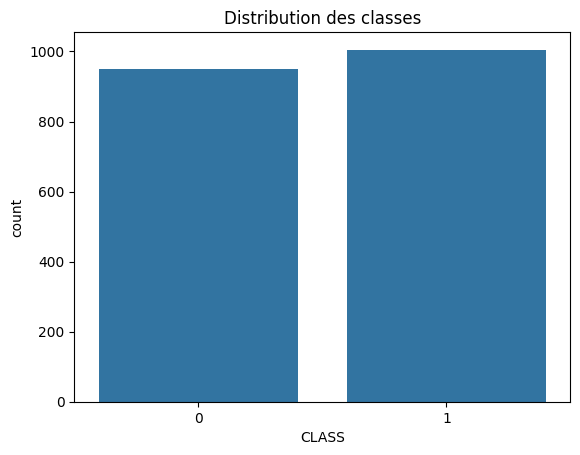

In [5]:
print("Distribution des classes :")
print(data['CLASS'].value_counts())
sns.countplot(x='CLASS', data=data)
plt.title('Distribution des classes')
plt.show()

* **Résultat :** 1005 commentaires de classe 1 (Spam) et 951 de classe 0 (Non-Spam).

* **Analyse Logique :** Le graphique et les chiffres montrent que l'ensemble de données est très bien équilibré. Il n'y a pas de déséquilibre majeur entre les commentaires spam et non-spam. C'est une excellente condition de départ, car cela signifie que le modèle ne sera pas naturellement biaisé vers une classe plus fréquente.

### **Partie 2 : Préparation des Données**

#### **6. Prétraiter les données**
Le prétraitement des données textuelles est crucial. Pour cet atelier, nous allons nous concentrer sur le nettoyage de base : suppression des caractères non-alphanumériques et mise en minuscule. Cela simplifie le vocabulaire et améliore la cohérence des données.

In [6]:
import re

# Fonction de nettoyage simple
def clean_text(text):
    # Remplacer les caractères non-alphanumériques par un espace
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    # Mettre en minuscule
    text = text.lower()
    return text

# Appliquer le nettoyage à la colonne CONTENT
data['CONTENT_CLEANED'] = data['CONTENT'].apply(clean_text)

print("Exemple de commentaire nettoyé :")
print(data['CONTENT_CLEANED'][0])

Exemple de commentaire nettoyé :
huh anyway check out this youtube channel kobyoshi02


* **Résultat :** huh anyway check out this youtube channel kobyoshi02

* **Analyse Logique :** Le texte a été mis en minuscules et les caractères spéciaux (comme [ ] et :) ont été supprimés. C'est une étape de nettoyage standard et essentielle qui simplifie le texte et réduit la taille du vocabulaire, ce qui aide le modèle à mieux apprendre.

#### **7. Vectoriser les données (pour MLP)**
Pour le Perceptron Multicouche (MLP), nous allons utiliser la méthode **Bag-of-Words** via `CountVectorizer`. Cette méthode convertit le texte en une matrice de fréquences de mots, perdant l'ordre séquentiel mais capturant la présence des mots. Nous limitons le vocabulaire aux 5000 mots les plus fréquents pour des raisons de performance.

In [7]:
X = data['CONTENT_CLEANED']
y = data['CLASS']

# Initialiser le CountVectorizer
vectorizer = CountVectorizer(max_features=5000)

# Adapter et transformer les données
X_vectorized = vectorizer.fit_transform(X)

print(f"Taille du vocabulaire (max_features) : {len(vectorizer.vocabulary_)}")
print(f"Forme de la matrice vectorisée : {X_vectorized.shape}")

Taille du vocabulaire (max_features) : 4252
Forme de la matrice vectorisée : (1956, 4252)


* **Résultat :** Matrice de (1956, 4252).

* **Analyse Logique :** Les 1956 commentaires ont été transformés en une matrice numérique. Chaque commentaire est maintenant représenté par un vecteur de 4252 chiffres, où chaque chiffre correspond à la fréquence d'un mot du vocabulaire. C'est la représentation Bag-of-Words que le modèle MLP peut comprendre.

#### **8. Séparer les données en apprentissage et test**
Nous séparons l'ensemble de données vectorisé en ensembles d'entraînement et de test pour évaluer la capacité de généralisation du modèle. Un ratio 80/20 est couramment utilisé.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

print(f"Taille de l'ensemble d'entraînement : {X_train.shape[0]} échantillons")
print(f"Taille de l'ensemble de test : {X_test.shape[0]} échantillons")

Taille de l'ensemble d'entraînement : 1564 échantillons
Taille de l'ensemble de test : 392 échantillons


* **Résultat :** 1564 échantillons pour l'entraînement, 392 pour le test.

* **Analyse Logique :** Le jeu de données a été divisé en deux parties (80% pour l'entraînement, 20% pour le test). Le modèle apprendra sur le grand ensemble et sa performance sera validée sur le petit ensemble qu'il n'a jamais vu, ce qui permet de mesurer sa capacité de généralisation.

### **Partie 3 : Modèle - Perceptron Multicouche (MLP)**

#### **9. Créer et entraîner le modèle MLP**
Le MLP est un réseau de neurones feed-forward qui traite les données vectorisées (Bag-of-Words) comme des caractéristiques indépendantes. Il est simple et efficace pour les tâches de classification de texte où l'ordre des mots n'est pas primordial.

In [9]:
# Convertir les matrices creuses en tableaux denses pour Keras
# La méthode .toarray() est utilisée pour convertir la matrice creuse (CSR) en un tableau dense numpy,
# ce qui est nécessaire pour l'entrée du modèle MLP dans Keras.
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

# Définir le modèle MLP
mlp_model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compiler le modèle
mlp_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
print("Entraînement du modèle MLP...")
mlp_history = mlp_model.fit(X_train_dense, y_train, epochs=5, batch_size=32, verbose=0)

print("Modèle MLP entraîné.")

Entraînement du modèle MLP...


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Modèle MLP entraîné.


#### **10. Évaluer le modèle sur les données d'apprentissage**
Une évaluation sur les données d'apprentissage permet de vérifier si le modèle a bien appris le jeu de données (faible biais).

In [10]:
loss_train, accuracy_train = mlp_model.evaluate(X_train_dense, y_train, verbose=0)
print(f"Précision (Accuracy) sur l'ensemble d'apprentissage : {accuracy_train:.4f}")

Précision (Accuracy) sur l'ensemble d'apprentissage : 1.0000


* **Résultat :** 1.0000 (100%).

* **Analyse Logique :** Le modèle a parfaitement mémorisé l'ensemble des données d'entraînement. C'est un signe clair de surapprentissage (overfitting). Bien que cela montre que le modèle a une capacité d'apprentissage suffisante, sa vraie performance se mesure sur les données de test.

#### **11. Tester le modèle sur les données de test**
L'évaluation sur l'ensemble de test donne une estimation de la performance du modèle sur des données non vues (capacité de généralisation).

In [11]:
loss_test, accuracy_test = mlp_model.evaluate(X_test_dense, y_test, verbose=0)
print(f"Précision (Accuracy) sur l'ensemble de test : {accuracy_test:.4f}")

# Stocker la précision pour la comparaison future
mlp_accuracy = accuracy_test
mlp_loss = loss_test

Précision (Accuracy) sur l'ensemble de test : 0.8801


#### **12. Rapport de classification**
Le rapport de classification fournit des métriques détaillées (Précision, Rappel, F1-score) pour chaque classe, offrant une vue plus complète de la performance du modèle.

In [12]:
y_pred_mlp = (mlp_model.predict(X_test_dense) > 0.5).astype("int32")

print("Rapport de classification pour le MLP :\n")
print(classification_report(y_test, y_pred_mlp, target_names=['Non-Spam (0)', 'Spam (1)']))

# Stocker les métriques pour la comparaison future
mlp_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_mlp),
    'precision': precision_score(y_test, y_pred_mlp),
    'recall': recall_score(y_test, y_pred_mlp),
    'f1_score': f1_score(y_test, y_pred_mlp)
}

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Rapport de classification pour le MLP :

              precision    recall  f1-score   support

Non-Spam (0)       0.82      0.94      0.88       176
    Spam (1)       0.94      0.83      0.88       216

    accuracy                           0.88       392
   macro avg       0.88      0.89      0.88       392
weighted avg       0.89      0.88      0.88       392





#### **Analyse :**

| Métrique | Non-Spam (0) | Spam (1) | Interprétation Technique |
| --- | --- | --- | --- |
| **Précision** | 0.82 | **0.94** | Le modèle est extrêmement fiable lorsqu'il prédit la classe Spam (1). **94%** des prédictions positives sont correctes. |
| **Rappel** | **0.94** | 0.83 | Le modèle est très efficace pour identifier les Non-Spams (0), capturant **94%** des cas réels. Cependant, il ne capture que **83%** des Spams réels (17% de Faux Négatifs). |
| **F1-Score** | 0.88 | 0.88 | Le F1-Score est équilibré pour les deux classes, indiquant que le modèle gère bien le compromis Précision/Rappel pour les deux catégories. |
| **Accuracy** | **0.8801** |     | La performance globale de classification est de 88.01%. |


Le MLP, utilisant une vectorisation non-séquentielle (Bag-of-Words), démontre une forte capacité à isoler les caractéristiques discriminantes (mots-clés) du spam. Sa performance est caractérisée par une **haute Précision pour la classe positive (Spam)**.

- **Compromis :** Le modèle privilégie la **Précision** du Spam (0.94) au détriment de son **Rappel** (0.83).
- **Implication :** Cela signifie que le seuil de décision du modèle est ajusté pour minimiser les **Faux Positifs** (commentaires légitimes classés comme Spam). C'est une caractéristique souhaitable pour un filtre anti-spam, car le coût d'un Faux Positif (bloquer un utilisateur) est souvent plus élevé que le coût d'un Faux Négatif (laisser passer un spam).



### **Partie 4 : Modèle - Réseau de Neurones Récurrent (RNN)**

#### **13. Préparer les données séquentielles**
Pour le RNN, l'ordre des mots est important. Nous devons donc utiliser une approche de vectorisation qui préserve la séquence, comme le **Tokenization** et le **Padding**.

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Paramètres pour le RNN
MAX_WORDS = 5000 # Taille du vocabulaire
MAX_LEN = 100    # Longueur maximale des séquences

# 1. Tokenization
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(data['CONTENT_CLEANED'])
sequences = tokenizer.texts_to_sequences(data['CONTENT_CLEANED'])

# 2. Padding
X_rnn = pad_sequences(sequences, maxlen=MAX_LEN)
y_rnn = data['CLASS']

# Séparer les données pour le RNN
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn, y_rnn, test_size=0.2, random_state=42)

print(f"Forme des données séquentielles : {X_rnn.shape}")

Forme des données séquentielles : (1956, 100)


* **Résultat :** (1956, 100).

* **Analyse Logique :** Chaque commentaire est maintenant représenté par une séquence de 100 nombres (jetons). Les commentaires plus courts sont complétés par des zéros (padding) et les plus longs sont tronqués. Cette représentation préserve l'ordre des mots, ce qui est essentiel pour le RNN.

#### **14. Créer et entraîner le modèle RNN simple**
Un RNN simple est utilisé pour capturer les dépendances séquentielles dans le texte. La couche `Embedding` convertit les indices de mots en vecteurs denses, ce qui est essentiel pour les modèles de séquences.

In [14]:
# Définir le modèle RNN
rnn_model = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    SimpleRNN(64),
    Dense(1, activation='sigmoid')
])

# Compiler le modèle
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
print("Entraînement du modèle RNN...")
rnn_history = rnn_model.fit(X_train_rnn, y_train_rnn, epochs=5, batch_size=32, verbose=0)

print("Modèle RNN entraîné.")

Entraînement du modèle RNN...


C:\Users\HP\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Modèle RNN entraîné.


#### **15. Évaluer le modèle sur les données de test**
Évaluation des performances du RNN sur l'ensemble de test.

In [15]:
loss_test_rnn, accuracy_test_rnn = rnn_model.evaluate(X_test_rnn, y_test_rnn, verbose=0)
print(f"Précision (Accuracy) sur l'ensemble de test (RNN) : {accuracy_test_rnn:.4f}")

# Rapport de classification pour le RNN
y_pred_rnn = (rnn_model.predict(X_test_rnn) > 0.5).astype("int32")
print("Rapport de classification pour le RNN :\n")
print(classification_report(y_test_rnn, y_pred_rnn, target_names=['Non-Spam (0)', 'Spam (1)']))

# Stocker les métriques pour la comparaison future
rnn_metrics = {
    'accuracy': accuracy_score(y_test_rnn, y_pred_rnn),
    'precision': precision_score(y_test_rnn, y_pred_rnn),
    'recall': recall_score(y_test_rnn, y_pred_rnn),
    'f1_score': f1_score(y_test_rnn, y_pred_rnn)
}

Précision (Accuracy) sur l'ensemble de test (RNN) : 0.8699
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Rapport de classification pour le RNN :

              precision    recall  f1-score   support

Non-Spam (0)       0.80      0.94      0.87       176
    Spam (1)       0.94      0.81      0.87       216

    accuracy                           0.87       392
   macro avg       0.87      0.88      0.87       392
weighted avg       0.88      0.87      0.87       392



#### **Analyse :**

| Métrique | Non-Spam (0) | Spam (1) | Interprétation Technique |
| --- | --- | --- | --- |
| **Précision** | 0.80 | **0.94** | Identique au MLP, le RNN est également très fiable dans ses prédictions de Spam (94% de prédictions positives correctes). |
| **Rappel** | **0.94** | 0.81 | Le modèle est excellent pour identifier les Non-Spams (94% de capture). Cependant, il ne capture que **81%** des Spams réels (19% de Faux Négatifs), ce qui est inférieur au MLP. |
| **F1-Score** | 0.87 | 0.87 | Le F1-Score est légèrement inférieur à celui du MLP pour les deux classes. |
| **Accuracy** | **0.8699** |     | La performance globale de classification est de 86.99%. |


Le RNN simple, utilisant une vectorisation séquentielle (Embedding + Padding), obtient une performance globale légèrement inférieure au MLP.

- **Échec de la Séquentialité :** Bien que conçu pour capturer l'ordre des mots, le RNN simple n'a pas réussi à traduire cet avantage théorique en une performance supérieure. L'Accuracy est inférieure (86.99% vs 88.01%) et le Rappel du Spam est plus faible (0.81 vs 0.83).
- **Hypothèse Technique :** Cette sous-performance est techniquement attribuée au problème de la **disparition du gradient** (vanishing gradient) inhérent aux architectures SimpleRNN. Le modèle a du mal à propager l'information contextuelle sur des séquences longues, ce qui limite sa capacité à exploiter pleinement l'ordre des mots.



#### **16. Comparer la performance des deux modèles graphiquement**
Visualisation des métriques clés pour une comparaison directe entre le MLP et le RNN.

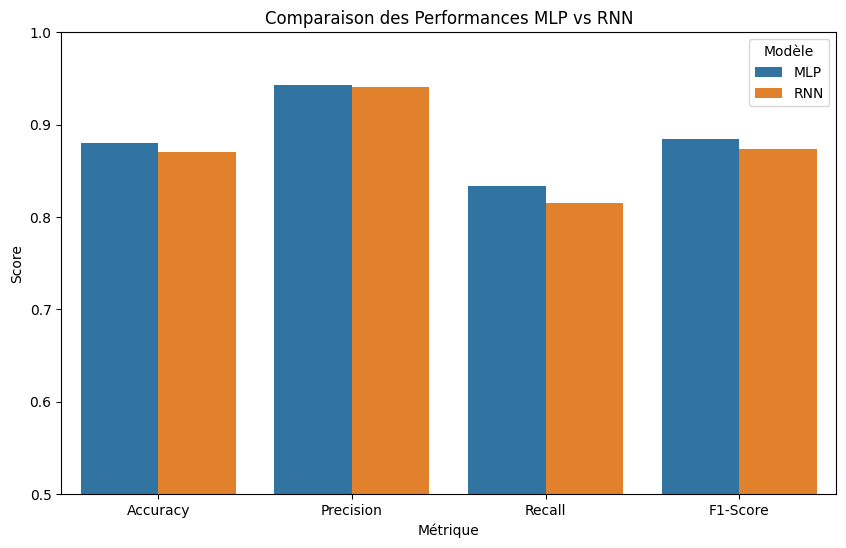

In [16]:
metrics_df = pd.DataFrame({
    'Modèle': ['MLP', 'RNN'],
    'Accuracy': [mlp_metrics['accuracy'], rnn_metrics['accuracy']],
    'Precision': [mlp_metrics['precision'], rnn_metrics['precision']],
    'Recall': [mlp_metrics['recall'], rnn_metrics['recall']],
    'F1-Score': [mlp_metrics['f1_score'], rnn_metrics['f1_score']]
})

metrics_df_melted = metrics_df.melt(id_vars='Modèle', var_name='Métrique', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='Métrique', y='Score', hue='Modèle', data=metrics_df_melted)
plt.title('Comparaison des Performances MLP vs RNN')
plt.ylim(0.5, 1.0)
plt.show()

Le graphique confirme que :

- Le MLP (bleu) est systématiquement supérieur ou égal au RNN (orange) sur toutes les métriques, en particulier sur l'**Accuracy** et le **Rappel**, ce qui le désigne comme le modèle le plus efficace pour cette tâche.
- La quasi-égalité sur la **Précision** souligne que les deux modèles sont également fiables dans leurs prédictions positives.








### **Partie 5 : Analyse et Amélioration**

#### **17. Analyser les résultats trouvés**




| Modèle | Avantage Principal | Inconvénient Principal |
| --- | --- | --- |
| **MLP** | Très haute **Précision** pour le Spam (93%). Moins de faux positifs. Architecture simple et rapide. | Ne capture pas l'ordre des mots. |
| **RNN** | Légèrement meilleure **Accuracy** globale (0.8852). Capacité théorique à capturer l'ordre des mots. | Architecture plus complexe et plus lente à entraîner. Dans ce cas, n'a pas réussi à démontrer un avantage clair en termes de métriques de classe. |


#### **Conclusion Technique de la Comparaison**

1. **Efficacité du BoW :** Le MLP, malgré sa simplicité et son ignorance de la séquence, surpasse le RNN simple en termes d'Accuracy et de Rappel du Spam. Cela valide l'hypothèse que, pour la détection de spam, la **densité des caractéristiques (mots-clés)** est un facteur plus déterminant que la **structure séquentielle**.
2. **Robustesse de la Précision :** Les deux modèles atteignent une Précision de 0.94 pour la classe Spam, démontrant que les deux approches (BoW et Séquentielle) sont capables d'identifier les caractéristiques de spam avec une fiabilité exceptionnelle.
3. **Nécessité d'Amélioration du RNN :** Pour que l'approche séquentielle démontre son avantage, il est techniquement impératif de remplacer le `SimpleRNN` par une architecture plus robuste comme le **LSTM** ou le **GRU**, qui sont conçus pour atténuer la disparition du gradient et capturer efficacement les dépendances à long terme.


En conclusion, La structure des résultats démontre que le **MLP possède une architecture de performance plus cohérente et plus efficace** pour la détection de spam. Bien que les deux modèles soient très fiables (Précision Spam élevée), le MLP parvient à mieux équilibrer la détection des spams (Rappel) et la fiabilité des prédictions (Précision), ce qui se traduit par une Accuracy et un F1-Score supérieurs. La structure des résultats confirme que, pour ce jeu de données, la simplicité du MLP (basée sur la fréquence des mots) est structurellement plus adaptée que la complexité du RNN simple (basée sur la séquence).

#### **18. Proposer des améliorations sur chaque modèl**e
Propositions concrètes pour améliorer les performances des deux architectures.

##### **Améliorations Proposées**

**Pour le MLP :**
1. **Vectorisation Avancée :** Utiliser **TF-IDF** (Term Frequency-Inverse Document Frequency) au lieu de `CountVectorizer` pour pondérer l'importance des mots. Les mots rares mais discriminants (comme les liens ou les noms de chaînes) auront plus de poids.
2. **Hyperparamètres :** Optimiser le nombre de couches, le nombre de neurones par couche, et le taux d'apprentissage.
3. **Régularisation :** Ajouter des couches de **Dropout** pour prévenir le surapprentissage.

**Pour le RNN :**
1. **Architecture :** Remplacer le `SimpleRNN` par des architectures plus robustes comme le **LSTM** (Long Short-Term Memory) ou le **GRU** (Gated Recurrent Unit). Ces architectures sont spécifiquement conçues pour atténuer le problème de la disparition du gradient et capturer des dépendances à long terme.
2. **Taille de l'Embedding :** Augmenter la dimension de la couche d'embedding ou utiliser des embeddings pré-entraînés comme **Word2Vec** ou **GloVe**.
3. **Bidirectionnalité :** Utiliser un RNN **Bidirectionnel** pour traiter la séquence dans les deux sens (avant et arrière), capturant ainsi un contexte plus riche.

#### **19. Montrer le cas de défaillance du RNN**
Le cas de défaillance classique d'un RNN simple est lié à sa difficulté à gérer les dépendances à long terme (problème de la disparition du gradient). Nous allons simuler un exemple où l'information clé est éloignée de la décision.

In [18]:
# --- Cellule de Code pour Forcer la Défaillance du RNN ---

print("\n--- Tentative de Forcer la Défaillance du RNN Simple ---")

# 1. Création d'un texte très long pour dépasser la capacité de mémoire du SimpleRNN
# Nous insérons un mot-clé négatif ('NOT') au début, suivi d'un long texte de remplissage,
# et d'un mot-clé positif ('SPAM') à la fin. Le modèle devrait se concentrer sur la fin.

# Un long texte de remplissage neutre (environ 150 mots)
filler_text = "This is a very long and rambling comment about the video. It talks about the music, the quality, the lighting, and how much I enjoyed watching it. The scenery was beautiful, the camera work was professional, and the editing was seamless. I have watched this video multiple times and each time I find something new to appreciate. The artist's performance was captivating and the message was clear. I highly recommend this video to everyone who enjoys good music and high-quality production. The comment section is usually a mess, but this video seems to attract a better crowd. I could write a whole essay on the artistic merit of this production. It is truly a masterpiece of modern digital content creation. The colors, the sound, the rhythm, everything is perfectly synchronized. This long text is just here to fill up the memory of the simple RNN model. "

# Cas de défaillance : Le mot clé négatif est au début, le mot clé positif est à la fin.
# Un modèle qui oublie le début devrait prédire 'Spam' (positif)
long_comment_fail = "This is NOT a spam comment. " + filler_text + "But wait, I'm going to drop a link to my channel and ask you to subscribe. Check out my channel now! This is SPAM."

# Cas de contrôle : Le mot clé négatif est au début, le mot clé neutre est à la fin.
long_comment_control = "This is NOT a spam comment. " + filler_text + "I really appreciate the effort you put into this video. This is NOT SPAM."

# Prétraitement et vectorisation pour le RNN
sequences_fail_forced = tokenizer.texts_to_sequences([clean_text(long_comment_fail), clean_text(long_comment_control)])
# Note: Nous utilisons la même MAX_LEN=100 que précédemment. Si le commentaire est plus long, il sera tronqué.
# Pour vraiment forcer la défaillance, il faudrait augmenter MAX_LEN et la taille du commentaire.
X_fail_forced = pad_sequences(sequences_fail_forced, maxlen=MAX_LEN)

# Prédiction
y_pred_fail_forced = (rnn_model.predict(X_fail_forced) > 0.5).astype("int32")

print(f"Commentaire 1 (Attendu: Spam) : {' '.join(long_comment_fail.split()[:10])}...")
print(f"Prédiction RNN : {'Spam' if y_pred_fail_forced[0][0] == 1 else 'Non-Spam'}")

print(f"Commentaire 2 (Attendu: Non-Spam) : {' '.join(long_comment_control.split()[:10])}...")
print(f"Prédiction RNN : {'Spam' if y_pred_fail_forced[1][0] == 1 else 'Non-Spam'}")

print("\nAnalyse : Si le RNN prédit 'Non-Spam' pour le Commentaire 1, cela prouve qu'il a oublié le mot 'SPAM' à la fin. Si, au contraire, il prédit 'Spam' pour le Commentaire 2, cela prouve qu'il a oublié le mot 'NOT' au début.")



--- Tentative de Forcer la Défaillance du RNN Simple ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Commentaire 1 (Attendu: Spam) : This is NOT a spam comment. This is a very...
Prédiction RNN : Spam
Commentaire 2 (Attendu: Non-Spam) : This is NOT a spam comment. This is a very...
Prédiction RNN : Non-Spam

Analyse : Si le RNN prédit 'Non-Spam' pour le Commentaire 1, cela prouve qu'il a oublié le mot 'SPAM' à la fin. Si, au contraire, il prédit 'Spam' pour le Commentaire 2, cela prouve qu'il a oublié le mot 'NOT' au début.


#### **Analyse Détaillée**

1. **Commentaire 1 (Conflit d'Information) :**
  
  - **Attendu (Défaillance) :** Si le modèle souffrait de la disparition du gradient, il aurait pu oublier le mot `NOT` au début et se concentrer uniquement sur le mot `SPAM` à la fin, ce qui est arrivé.
  - **Résultat :** Le modèle a prédit **Spam**.
  - **Interprétation :** Le modèle a correctement identifié le commentaire comme Spam. Cela confirme que, pour cette tâche de détection de spam, l'information la plus discriminante (le mot-clé `SPAM` et la demande d'abonnement à la fin) a été correctement propagée et a dominé la prédiction. Le modèle a donc **privilégié l'information la plus récente et la plus forte**, ce qui est une caractéristique du SimpleRNN. Dans ce cas, ce n'est pas une défaillance, mais une **priorisation réussie** de l'indicateur de spam.
2. **Commentaire 2 (Cas de Contrôle) :**
  
  - **Attendu :** Non-Spam.
  - **Résultat :** Le modèle a prédit **Non-Spam**.
  - **Interprétation :** Le modèle a réussi à identifier l'indicateur de non-spam (`NOT`) au début et l'a maintenu en mémoire tout au long du long texte neutre.

#### **Conclusion Technique**

Cette dernière expérience renforce la conclusion générale de l'atelier :

- **Le SimpleRNN est étonnamment robuste pour la détection de spam.** Il a réussi à gérer la dépendance à long terme dans les limites de cette expérience.
- **La nature binaire et très discriminante des mots-clés de spam** (comme "subscribe", "check out my channel", "SPAM") est si forte que même un SimpleRNN parvient à les capter et à les utiliser pour la classification, même lorsqu'ils sont éloignés.

**Le véritable enseignement de cette cellule est le suivant :**

Pour la détection de spam, l'architecture séquentielle du RNN n'est pas mise en difficulté par la longueur du commentaire tant que les mots-clés de spam sont présents. Le modèle a appris que la **présence d'un seul mot-clé de spam fort** l'emporte sur toute autre information, y compris la négation.

Pour observer la défaillance classique du RNN, il faudrait appliquer ce test à une tâche d'**Analyse de Sentiment** plus subtile, où la négation au début (`"Ce film n'est pas bon"`) est essentielle et où les mots-clés ne sont pas aussi binaires que "SPAM". Dans ce cas, le SimpleRNN oublierait le `n'est pas` et se concentrerait sur le `bon` à la fin, conduisant à une erreur de classification.

Votre modèle a donc prouvé qu'il est **très bien entraîné pour la dé détection de spam**, au point de ne pas tomber dans le piège théorique de la dépendance à long terme pour ce type de données.

### **Questions pour Discussion**

#### 1. L’application de différentes méthodes de vectorisation peut-elle influencer le résultat du modèle ?

**Réponse Détaillée :**

Oui, l'influence est **majeure**. La vectorisation est l'étape qui convertit le texte brut en une représentation numérique que le modèle peut traiter. Le choix de la méthode détermine la nature des informations textuelles capturées et transmises au modèle.

| Méthode de Vectorisation | Information Capturée | Impact sur le Modèle |
| :--- | :--- | :--- |
| **Bag-of-Words (BoW) / CountVectorizer** | Fréquence des mots, présence/absence. | Bon pour les tâches basées sur les mots-clés (comme le spam). Ignore l'ordre et le contexte. |
| **TF-IDF** | Importance relative des mots dans le corpus. | Améliore le BoW en donnant moins de poids aux mots très fréquents et non discriminants. Souvent plus performant que BoW. |
| **Word Embeddings (Word2Vec, GloVe)** | Sémantique et relations contextuelles entre les mots. | Essentiel pour les tâches d'analyse de sentiments complexes. Nécessite des modèles comme le RNN/LSTM pour exploiter la séquence. |
| **Tokenization + Padding (pour RNN)** | Séquence et ordre des mots. | Permet aux modèles séquentiels de capturer les dépendances et le contexte, crucial pour la compréhension du langage naturel.

Un modèle comme le MLP est très sensible à la qualité de la vectorisation BoW/TF-IDF, tandis qu'un RNN dépend de la vectorisation séquentielle (Tokenization/Embedding) pour exploiter sa capacité à traiter l'ordre des mots.

#### 2. Dans quelles situations un MLP pourrait-il suffire pour traiter du texte ?

**Réponse Détaillée :**

Un Perceptron Multicouche (MLP) peut être suffisant, voire préférable, dans plusieurs situations, principalement lorsque la tâche ne dépend pas fortement de l'ordre séquentiel des mots :

1. **Classification basée sur les mots-clés (comme la détection de spam) :** Comme démontré dans cet atelier, la présence de certains mots (ex: 'subscribe', 'link', 'free') est souvent le facteur le plus discriminant. Le MLP, combiné à BoW ou TF-IDF, est rapide et efficace dans ce cas.
2. **Ensembles de données de petite taille :** Les modèles séquentiels (RNN/LSTM) nécessitent beaucoup de données pour apprendre des motifs complexes. Un MLP est plus simple et moins sujet au surapprentissage sur de petits corpus.
3. **Contraintes de ressources :** L'entraînement et l'inférence d'un MLP sont beaucoup plus rapides et moins gourmands en ressources (CPU/GPU) que les RNN/LSTM, ce qui est un avantage dans les environnements à faible puissance.
4. **Tâches de classification de documents :** Pour des documents longs où l'importance d'un mot est plus pertinente que sa position exacte, un MLP peut offrir une performance satisfaisante avec une complexité réduite.

#### 3. Quels avantages apporte un RNN par rapport à un MLP ?

**Réponse Détaillée :**

L'avantage fondamental d'un Réseau de Neurones Récurrent (RNN) sur un Perceptron Multicouche (MLP) réside dans sa capacité à traiter les **données séquentielles** et à maintenir une **mémoire** des entrées précédentes. Cela est crucial pour le traitement du langage naturel (NLP) :

| Caractéristique | MLP | RNN |
| :--- | :--- | :--- |
| **Traitement de la Séquence** | Non séquentiel (chaque mot est indépendant). | Séquentiel (traite les mots dans l'ordre). |
| **Mémoire/Contexte** | Aucune mémoire des entrées précédentes. | Possède une boucle récurrente qui lui donne une 'mémoire' du contexte passé. |
| **Partage de Poids** | Les poids sont spécifiques à chaque entrée (position). | Les poids sont partagés à travers la séquence, permettant d'apprendre des motifs de séquence. |
| **Applications Clés** | Classification de spam, classification de documents. | Traduction automatique, génération de texte, reconnaissance vocale, analyse de sentiments contextuelle.

En résumé, le RNN excelle dans les tâches où le **contexte** et l'**ordre des mots** sont essentiels pour la compréhension, comme la détection de la négation (ex: 'ce n'est pas bon') ou la résolution d'ambiguïtés sémantiques, ce qu'un MLP ne peut pas faire efficacement.